In [47]:
import sys
sys.path.append('/home/bodo/GitHub/NFProject/glow2/glow-pytorch')

In [2]:
# parser = argparse.ArgumentParser(description="Glow trainer")
# parser.add_argument("--batch", default=16, type=int, help="batch size")
# parser.add_argument("--iter", default=200000, type=int, help="maximum iterations")
# parser.add_argument(
#     "--n_flow", default=32, type=int, help="number of flows in each block"
# )
# parser.add_argument("--n_block", default=4, type=int, help="number of blocks")
# parser.add_argument(
#     "--no_lu",
#     action="store_true",
#     help="use plain convolution instead of LU decomposed version",
# )
# parser.add_argument(
#     "--affine", action="store_true", help="use affine coupling instead of additive"
# )
# parser.add_argument("--n_bits", default=5, type=int, help="number of bits")
# parser.add_argument("--lr", default=1e-4, type=float, help="learning rate")
# parser.add_argument("--img_size", default=64, type=int, help="image size")
# parser.add_argument("--temp", default=0.7, type=float, help="temperature of sampling")
# parser.add_argument("--n_sample", default=20, type=int, help="number of samples")
# parser.add_argument("path", metavar="PATH", type=str, help="Path to image directory")


In [1]:
import sys
sys.path.append('/home/bodo/GitHub/NFProject/glow2/glow-pytorch')
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi

import argparse
import pathlib

import torch
from torch import nn, optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
from train import sample_data
from model import Glow

/home/bodo/.pyenv/versions/3.8.16/envs/nf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [3]:
args = Namespace(
  n_flow = 32
, n_block = 4
, affine = None
, no_lu = None
, lr = 1e-4
, path = '/home/bodo/GitHub/NFProject/data/img_align_celeba'
, batch = 32
, img_size = 64
)

In [4]:
device = 'cuda'
path = pathlib.Path('/home/bodo/GitHub/NFProject/glow2/glow-pytorch')

In [5]:
model_single = Glow(
    3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
)

model = nn.DataParallel(model_single)
# model = model_single
model = model.to(device)

/home/bodo/GitHub/NFProject/glow2/glow-pytorch/model.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  w_s = torch.from_numpy(w_s)


In [6]:
model.load_state_dict(torch.load(path / 'checkpoint/model_190001.pt'))

<All keys matched successfully>

In [7]:
dataset = iter(sample_data(args.path, args.batch, args.img_size))

In [8]:
X, y = next(dataset)

In [9]:
X.shape

torch.Size([32, 3, 64, 64])

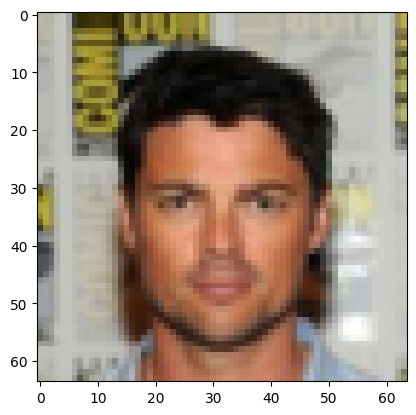

In [10]:
plt.imshow(X[1].permute(1,2,0).numpy())

In [11]:
_, _, z = model(X[0:1].cuda())

(array([1.000e+00, 4.000e+00, 1.800e+01, 1.230e+02, 1.506e+03, 3.803e+03,
        5.670e+02, 1.010e+02, 1.800e+01, 3.000e+00]),
 array([-14.34039688, -11.5644455 ,  -8.78849506,  -6.01254416,
         -3.23659325,  -0.46064234,   2.31530857,   5.09125948,
          7.86721039,  10.64316177,  13.41911221]),
 <BarContainer object of 10 artists>)

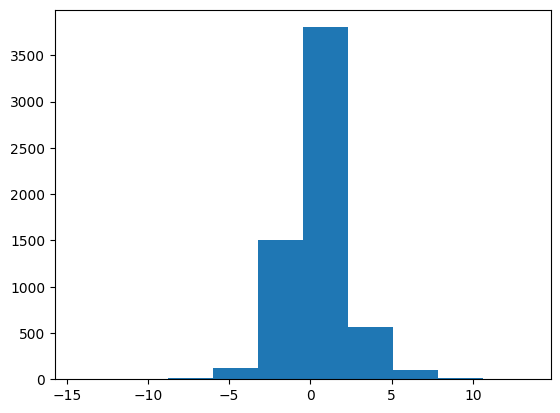

In [12]:
plt.hist(z[0].flatten().cpu().detach().numpy())

In [13]:
def fit_range(data):
    data = data - data.min()
    data = data / data.max()
    return data

In [14]:
for param in z:
    param.normal_()

/tmp/ipykernel_12179/2863261185.py:2: UserWarning: Output 1 of SplitBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  ../torch/csrc/autograd/variable.cpp:547.)
  param.normal_()


In [15]:
xhat = model.module.reverse(z, reconstruct=True).cpu().detach().squeeze().permute(1,2,0)

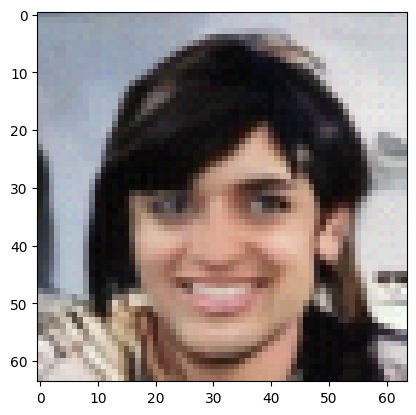

In [16]:
plt.imshow(fit_range(xhat))

# Check Inverse

In [17]:
img = X[1:2]

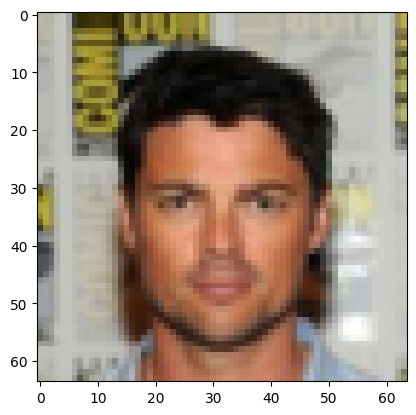

In [18]:
plt.imshow(img.squeeze().permute(1,2,0).numpy())

In [19]:
_, _, z = model.forward(img)

In [20]:
rev = model.module.reverse(z, reconstruct=True)

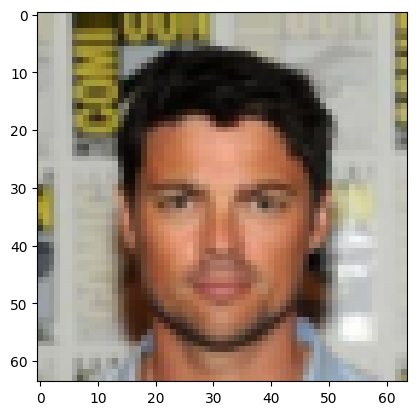

In [21]:
plt.imshow(rev.squeeze().permute(1,2,0).cpu().detach().numpy())

# Noise Removal

In [22]:
clear = X[1:2]
noisy = clear + 0.1*torch.rand_like(img)
noisy = noisy.clip(0, 1)

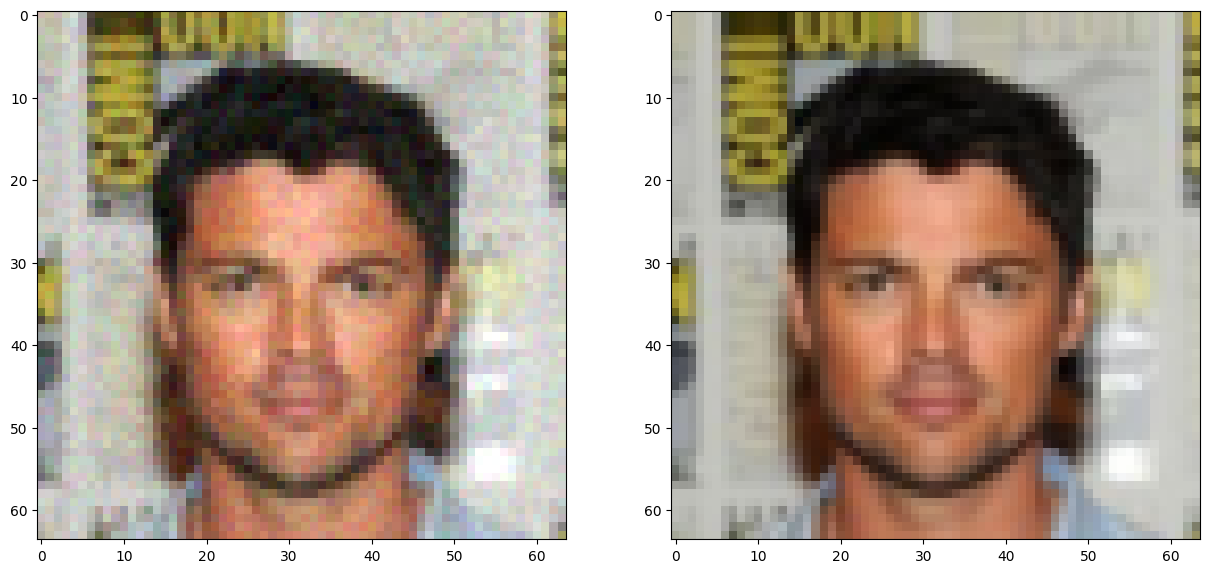

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,30))
ax[0].imshow(noisy.squeeze().permute(1,2,0).numpy())
ax[1].imshow(clear.squeeze().permute(1,2,0).numpy())

In [24]:
_, _, z_clear = model.forward(clear)
_, _, z_noisy = model.forward(noisy)

In [25]:
[c.abs().mean() for c, n in zip(z_clear, z_noisy)]

[tensor(1.6801, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.6313, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(5.2658, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.3262, device='cuda:0', grad_fn=<MeanBackward0>)]

In [26]:
[(n).abs().mean() for c, n in zip(z_clear, z_noisy)]

[tensor(4.0794, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(4.3597, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(6.3438, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.6227, device='cuda:0', grad_fn=<MeanBackward0>)]

In [27]:
[c.mean() for c, n in zip(z_clear, z_noisy)]

[tensor(0.5310, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0352, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2424, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1996, device='cuda:0', grad_fn=<MeanBackward0>)]

In [28]:
[n.mean() for c, n in zip(z_clear, z_noisy)]

[tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1137, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3401, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2201, device='cuda:0', grad_fn=<MeanBackward0>)]

In [29]:
[(c-n).abs().mean() for c, n in zip(z_clear, z_noisy)]

[tensor(3.5778, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(3.1923, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(3.5248, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.1651, device='cuda:0', grad_fn=<MeanBackward0>)]

In [30]:
[z.numel() for z in z]

[6144, 3072, 1536, 1536]

In [31]:
z_denoised = [c.abs().mean() * n / n.abs().mean() for c, n in zip(z_clear, z_noisy)]

In [32]:
[(d).abs().mean() for d in z_denoised]

[tensor(1.6801, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.6313, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(5.2658, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.3262, device='cuda:0', grad_fn=<MeanBackward0>)]

In [33]:
rev = model.module.reverse(z_denoised, reconstruct=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


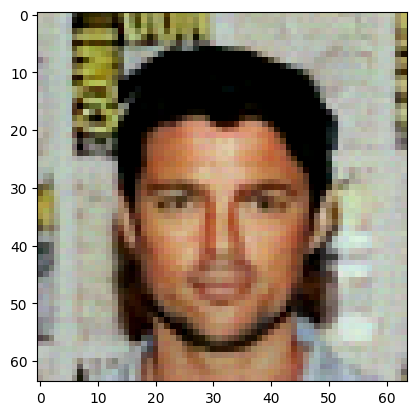

In [34]:
plt.imshow(rev.squeeze().permute(1,2,0).cpu().detach().numpy())

In [585]:
import sys
sys.path.append('/home/bodo/GitHub/NFProject/glow2/glow-pytorch')

In [586]:
from tqdm import tqdm, trange
import numpy as np
from PIL import Image
from math import log, sqrt, pi

import argparse
import pathlib

import torch
from torch import nn, optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
from train import sample_data
from model import Glow

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import cv2

In [587]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [588]:
class GaussianNoise(torch.nn.Module):
    def __init__(self, mean=0, std=1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, data):
        noise = torch.randn_like(data)
        return data + self.std * noise + self.mean

In [589]:
def fit_range(data):
    data = data - data.min()
    data = data / data.max()
    return data

In [590]:
def prepare_model(args, 
                  path='/home/bodo/GitHub/NFProject/glow2/glow-pytorch/checkpoint/model_190001.pt'):
    model = Glow(
        3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
    )
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(path))
    model = model.module.cpu()
    return model

In [591]:
def prepare_dataset(args):
    dataset = iter(sample_data(args.path, args.batch, args.img_size))
    X, y = next(dataset)
    return X, y

In [592]:
def reverse(model, z):
    return model.reverse(z, reconstruct=True).detach()

In [593]:
def preprocess(image, n_bits=5, n_bins=32):
    image = image * 255

    if n_bits < 8:
        image = torch.floor(image / 2 ** (8 - n_bits))

    image = image / n_bins - 0.5
    return image

In [594]:
def noise_comparison(norm_flow, noise_model, clear, n=16):

    clear = preprocess(clear)
    
    noise = noise_model(clear.repeat(n, 1, 1, 1))
    print(noise.shape)
    logp_clear, logdet_clear, z_clear = norm_flow(clear)
    logp_noise, logdet_noise, z_noise = norm_flow(noise)
    print(logdet_clear.shape)
    print(logdet_noise.shape)
    print(logdet_clear)
    z_res = [(n-c).cpu() for n, c in zip(z_noise, z_clear)]
    logp_res = (logp_noise - logp_clear).cpu()
    logdet_res = (logdet_noise - logdet_clear).cpu()

    return logp_res, logdet_res, z_res

In [595]:
class Delta(torch.nn.Module):
    def __init__(self, like):
        super().__init__()
        self.delta = torch.nn.Parameter(torch.randn_like(like)/100)
        
    def forward(self, data):
        return self.delta + data

In [596]:
def denoise(flow, noisy, delta=None, sigma=1, beta=1, iterations=1024, lr=0.1, opt=None, device='cpu'):
    
    flow = flow.to(device)
    noisy = noisy.to(device)
    
    delta = Delta(noisy) if not delta else delta
    delta = delta.to(device)
    
    opt = torch.optim.Adam(delta.parameters()) if not opt else opt
    opt.lr = lr
    opt.weight_decay = 0

    beta *= 0.5 / (sigma**2)

    metadata = {
        'log_likelihood': [],
        'log_prior': []
    }
    
    for _ in (pbar := trange(iterations)):
        
        opt.zero_grad()
        
        logp, logdet, _ = flow(delta(noisy))
        log_prior = logp + logdet
        log_likelihood = - beta * delta.delta.pow(2).sum()
        
        loss = - log_likelihood - log_prior
        loss.backward()
        opt.step()

        metadata['log_likelihood'].append(log_likelihood.item())
        metadata['log_prior'].append(log_prior.item())
        
        pbar.set_description(f'log_likelihood : {log_likelihood.item():.05f}  | log_prior = {log_prior.item():.05f}')

    return delta.cpu(), metadata

# Measuring Image Quality

In [597]:
def to_array(image):
    image = image.squeeze()
    if len(image.shape) == 3:
        image = image.permute(1,2,0)
    image = image.numpy()
    return image

def to_gray(image):
    if type(image) is torch.Tensor: 
        image = to_array(image)
    if len(image.shape) == 2:
        return image
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [598]:
def compute_metrics(noisy, denoised, clear, measures):
    noisy = to_gray(noisy)
    denoised = to_gray(denoised)
    clear = to_gray(clear)
    return {
        name: (measure(clear, noisy), measure(clear, denoised))
        for name, measure in measures.items()
    }

In [599]:
measures = {
    'mse' : mean_squared_error,
    'psnr': lambda x, y: peak_signal_noise_ratio(x, y, data_range=1),
    'ssim': lambda x, y: structural_similarity(x, y, data_range=1)
}

In [600]:
def create_comparison(flow, sample, sigmas, betas, iterations=1000, lr=0.1, device='cuda', repeat=1, measures=measures):
    flow = flow.to(device)
    STATS = []
    for clear in sample:
        
        stats = dict()
        STATS.append(stats)

        clear = preprocess(clear.unsqueeze(0)).to(device)
        with torch.no_grad():
            logp, logdet, _ = flow(clear)

        stats['clear'] = clear.cpu()
        stats['clear_log_likelihood'] = (logp + logdet).item()
        stats['clear_losses'] = {
            'logp': logp.item(),
            'logdet': logdet.item(),
        }
        stats['deltas'] = []

        for _ in range(repeat):
            
            stats_i = dict()
            stats['deltas'].append(stats_i)
            
            for sigma in sigmas:
                noise_model = GaussianNoise(0, sigma)
                noisy = noise_model(clear)
                for beta in betas:
                    delta, metadata = denoise(
                        flow,
                        noisy,
                        sigma=sigma,
                        beta=beta,
                        iterations=iterations,
                        lr=lr,
                        device=device
                    )

                    with torch.no_grad():
                        delta = delta.to(device)
                        denoised = delta(noisy).detach().cpu()
                        delta = delta.cpu()
                    
                    metrics = compute_metrics(
                        noisy.cpu(),
                        denoised.cpu(),
                        clear.cpu(),
                        measures
                    )
                    
                    stats_i[(sigma, beta)] = {
                        'noisy': noisy.cpu(),
                        'delta': delta.cpu(),
                        'denoised': denoised.cpu(),
                        'metadata': metadata,
                        'metrics': metrics,
                    }
                    
    return STATS
                

In [601]:
args = Namespace(
      n_flow = 32
    , n_block = 4
    , affine = None
    , no_lu = None
    , lr = 1e-4
    # , path = '/home/bodo/GitHub/NFProject/data/img_align_celeba'
    , path = '/home/bodo/GitHub/NFProject/data/test'
    , batch = 32
    , img_size = 64
)

In [602]:
torch.manual_seed(123)
X, y = prepare_dataset(args)
model = prepare_model(args).cpu()

In [603]:
try: 
    comparison_small = create_comparison(model, X, [0.025, 0.05], [1, 2, 4, 8], iterations=250, lr=0.1, device='cuda', repeat=1)
    torch.save(comparison_small, "small_noises.pt")
except Exception as e:
    print(e)

log_likelihood : -6181.97412  | log_prior = 40310.21875: 100%|████████████████████████████████████████████| 250/250 [01:10<00:00,  3.56it/s]
log_likelihood : -6325.96582  | log_prior = 35936.12500: 100%|████████████████████████████████████████████| 250/250 [01:14<00:00,  3.36it/s]
log_likelihood : -4716.95703  | log_prior = 30369.28516: 100%|████████████████████████████████████████████| 250/250 [01:16<00:00,  3.27it/s]
log_likelihood : -2991.38184  | log_prior = 25976.70312: 100%|████████████████████████████████████████████| 250/250 [01:10<00:00,  3.56it/s]
log_likelihood : -7417.14307  | log_prior = 44498.38281: 100%|████████████████████████████████████████████| 250/250 [01:10<00:00,  3.53it/s]
log_likelihood : -11420.60254  | log_prior = 41202.57812: 100%|███████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s]
log_likelihood : -11895.09277  | log_prior = 31969.92188: 100%|███████████████████████████████████████████| 250/250 [01:09<00:00,  3.58it/s]
log_likelihoo

In [604]:
try:
    comparison_big = create_comparison(model, X, [0.1, 0.2], [1, 4], iterations=750, lr=0.1, device='cuda', repeat=1)
    torch.save(comparison_big, "big_noises.pt")
except Exception as e:
    print(e)

log_likelihood : -8910.25977  | log_prior = 53500.81250: 100%|████████████████████████████████████████████| 750/750 [03:22<00:00,  3.71it/s]
log_likelihood : -20478.81445  | log_prior = 37911.95703: 100%|███████████████████████████████████████████| 750/750 [03:21<00:00,  3.73it/s]
log_likelihood : -4973.23145  | log_prior = 30332.46875: 100%|████████████████████████████████████████████| 750/750 [03:20<00:00,  3.73it/s]
log_likelihood : -9303.06055  | log_prior = 14454.86328: 100%|████████████████████████████████████████████| 750/750 [03:21<00:00,  3.73it/s]
log_likelihood : -9374.08105  | log_prior = 52703.51953: 100%|████████████████████████████████████████████| 750/750 [03:21<00:00,  3.72it/s]
log_likelihood : -20461.41992  | log_prior = 38639.80469: 100%|███████████████████████████████████████████| 750/750 [03:22<00:00,  3.71it/s]
log_likelihood : -4712.22266  | log_prior = 27881.27930: 100%|████████████████████████████████████████████| 750/750 [03:22<00:00,  3.71it/s]
log_likelihoo

In [623]:
comparison_small[0]['deltas'][0][(0.05, 8)]['metrics']

{'mse': (0.001072243645389896, 0.0008486592288226528),
 'psnr': (29.697065189105544, 30.712666616417366),
 'ssim': (0.893854022234253, 0.9113468643251306)}

In [ ]:
_, _, z = model(noisy)


# z[0] = torch.randn_like(z[0])
# z[1] = torch.randn_like(z[1])
# z[2] = torch.randn_like(z[2])
# z[3] = torch.randn_like(z[3])

# z[0].zero_()
# z[1].zero_()
# z[2].zero_()
# z[3].zero_()

c = 5
z[0] /= c
z[1] /= c
z[2] /= c
z[3] /= c

denoised = reverse(model, z)

fig, ax = plt.subplots(1, 3, figsize=(15,30))

ax[0].imshow(fit_range(noisy.squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))

In [ ]:
Policzyć:
- dla różnych beta
    - dla beta wskazanego przez model
- dla różnych gainów szumu


W pracy:
- wstęp teoretyczny 1 strona
- wyjaśnienie metody 0.5 strony
- tabelka - opis 0.5 strony
- zdjęcia - opis 0.5 strony
- bibliografia 0.5 strony 

# Test

In [549]:
delta = Delta(noisy)
opt = torch.optim.Adam(delta.parameters())

In [512]:
delta, metadata = denoise(model, preprocess(noisy), delta=delta, sigma=0.2, beta=4, iterations=250, device='cuda')

log_likelihood : -27622.72266  | log_prior = 52940.91016: 100%|███████████████████████████████████████████| 250/250 [01:08<00:00,  3.65it/s]


Text(0.5, 1.0, 'original')

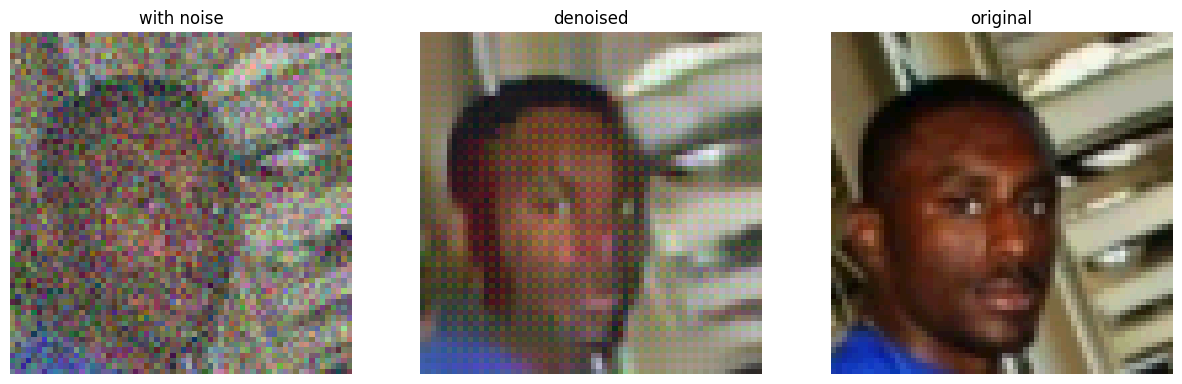

In [516]:
denoised = delta(preprocess(noisy)).detach()
denoised += 0.5
denoised[:, :, 1::2, 1::2] *= 1.00 - 0.1
denoised -= 0.5

fig, ax = plt.subplots(1,3, figsize=(15,30))

ax[0].imshow(fit_range(preprocess(noisy).squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(preprocess(clear).squeeze().permute(1,2,0).numpy()))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('with noise')
ax[1].set_title('denoised')
ax[2].set_title('original')

# Comparison

In [949]:
compute_metrics(preprocess(noisy), denoised, preprocess(clear), measures)

{'mse': (0.11172015731813575, 0.2736267704561351),
 'psnr': (9.518684614211743, 5.628414153853005),
 'ssim': (0.2453788268828554, 0.010940612275346902)}

In [950]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def denoise_kmeans(noisy):
    rgb_img = noisy.clip(0, 1).squeeze().permute(1,2,0).numpy()
    img = torch.stack([noisy[0, 0], noisy[0, 1], noisy[0, 2]]).clip(0, 1).permute(1, 2, 0).numpy()
    
    img = np.uint8(img * 255)
    rgb_img = np.uint8(rgb_img * 255)
    
    # Denoising
    dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    b,g,r = cv2.split(dst)           # get b, g, r
    rgb_dst = cv2.merge([r,g,b])     # switch it to rgb
    denoised = torch.tensor(dst / 255, dtype=torch.float32).permute(2, 0, 1)
    return denoised

In [951]:
denoised = denoise_kmeans(noisy)

Text(0.5, 1.0, 'original')

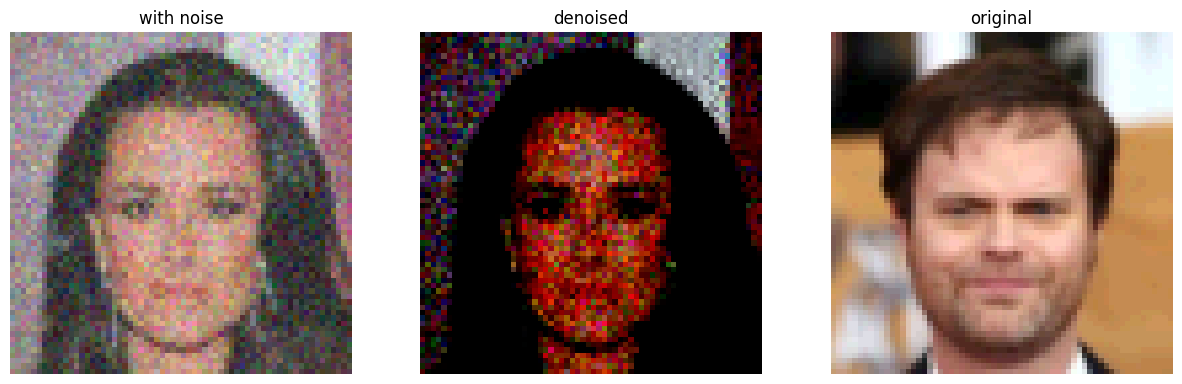

In [952]:
fig, ax = plt.subplots(1,3, figsize=(15,30))

ax[0].imshow(fit_range(noisy.squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('with noise')
ax[1].set_title('denoised')
ax[2].set_title('original')

In [368]:
compute_metrics(preprocess(noisy), preprocess(denoised), preprocess(clear), measures)

{'mse': (0.0011627027274410014, 0.0008087972291142189),
 'psnr': (29.345313087752643, 30.921603452786602),
 'ssim': (0.7863326211627152, 0.8605434295608051)}

In [626]:
model = model.cpu()

In [630]:
len(model.blocks)

4

In [633]:
len(model.blocks[0].flows)

32

In [637]:
len(model.blocks[1].flows)

32

In [638]:
len(model.blocks[2].flows)

32

In [639]:
len(model.blocks[3].flows)

32

# Small Analysis

In [641]:
len(comparison_small)

32

tensor([[[[-0.4688, -0.4688, -0.4688,  ...,  0.0938,  0.0625,  0.0312],
          [-0.4688, -0.4688, -0.4688,  ..., -0.0312, -0.0625, -0.0938],
          [-0.4688, -0.4688, -0.4688,  ..., -0.0625, -0.0938, -0.1250],
          ...,
          [-0.4062, -0.4375, -0.4062,  ..., -0.3438, -0.3438, -0.3750],
          [-0.4062, -0.4375, -0.4062,  ..., -0.3438, -0.3438, -0.3750],
          [-0.4062, -0.4062, -0.4062,  ..., -0.3750, -0.3750, -0.3438]],

         [[-0.4375, -0.4375, -0.4375,  ..., -0.1250, -0.1250, -0.1562],
          [-0.4375, -0.4375, -0.4375,  ..., -0.2188, -0.2500, -0.2812],
          [-0.4375, -0.4375, -0.4375,  ..., -0.2188, -0.2500, -0.2500],
          ...,
          [-0.3750, -0.3750, -0.3750,  ..., -0.3125, -0.3125, -0.3438],
          [-0.3750, -0.3750, -0.3750,  ..., -0.3438, -0.3125, -0.3438],
          [-0.3750, -0.3750, -0.3750,  ..., -0.3438, -0.3438, -0.3438]],

         [[-0.3750, -0.3750, -0.3750,  ..., -0.1250, -0.0938, -0.1250],
          [-0.4062, -0.4062, -

# Metrics

In [957]:
keys = sorted(comparison_small[0]['deltas'][0].keys())

In [1022]:

def get_table(measure='ssim'):
    betas = [1,2,4,8]
    sigmas = [0.025, 0.05]
    s = [""]
    def print(a, b='', end='\n'):
        s[0] += a
        s[0] += b
        s[0] += end
        
    print('\\toprule')
    print("$\sigma$ & $\\beta=1$ & $\\beta=2$ & $\\beta=4$ & $\\beta=8$ & noisy \\\\")
    print("\\midrule")
    for i in range(2):
        print(f' ${sigmas[i]}$' , end=' & ')
        for j in range(4):
            temp = [100*c['deltas'][0][(sigmas[i], betas[j])]['metrics'][measure][1] for c in comparison_small]
            print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", end=' & ')
            
        temp = [100*c['deltas'][0][(sigmas[i], betas[j])]['metrics'][measure][0] for c in comparison_small]
        print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", ' \\\\')
        # print(f"${comparison_small[0]['deltas'][0][(sigmas[i], betas[j])]['metrics']['ssim'][0]:.03f}$", ' \\\\')
    
    sigmas = [0.1, 0.2]
    for i in range(2):
        print(f' ${sigmas[i]}$' , end=' & ')
        for j in range(4):
            if betas[j] in [2,8]:
                print(' - ', end=' & ')
                continue
            temp = [100*c['deltas'][0][(sigmas[i], betas[j])]['metrics'][measure][1] for c in comparison_big]
            # print(f"{comparison_big[0]['deltas'][0][(sigmas[i], betas[j])]['metrics']['ssim'][1]:.05f}", end=' & ')
            print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", end=' & ')
        
        temp = [100*c['deltas'][0][(sigmas[i], betas[0])]['metrics'][measure][0] for c in comparison_big]
        print(f"${np.mean(temp):.03f} \pm {np.std(temp):.02f} $", ' \\\\')
        # print(f"${comparison_big[0]['deltas'][0][(sigmas[i], betas[0])]['metrics']['ssim'][0]:.03f}$", ' \\\\')
    print('\\bottomrule')

    return s[0].replace('0.', '.')

In [1023]:
print(get_table('ssim'))

\toprule
$\sigma$ & $\beta=1$ & $\beta=2$ & $\beta=4$ & $\beta=8$ & noisy \\
\midrule
 $.025$ & $96.409 \pm 1.44 $ & $98.108 \pm .71 $ & $97.647 \pm .64 $ & $96.299 \pm 1.29 $ & $94.911 \pm 1.95 $ \\
 $.05$ & $89.911 \pm 3.13 $ & $93.190 \pm 2.70 $ & $94.254 \pm 2.57 $ & $88.147 \pm 3.43 $ & $85.443 \pm 4.20 $ \\
 $.1$ & $68.932 \pm 5.91 $ &  -  & $84.085 \pm 5.64 $ &  -  & $67.810 \pm 6.23 $ \\
 $.2$ & $65.696 \pm 7.08 $ &  -  & $55.743 \pm 6.66 $ &  -  & $43.792 \pm 6.71 $ \\
\bottomrule



In [1024]:
print(get_table('psnr'))

\toprule
$\sigma$ & $\beta=1$ & $\beta=2$ & $\beta=4$ & $\beta=8$ & noisy \\
\midrule
 $.025$ & $3742.418 \pm 67.13 $ & $3938.908 \pm 57.59 $ & $3822.763 \pm 46.72 $ & $368.634 \pm 22.51 $ & $3552.960 \pm 8.18 $ \\
 $.05$ & $3217.068 \pm 44.33 $ & $3415.443 \pm 46.27 $ & $3397.558 \pm 73.10 $ & $3069.257 \pm 16.24 $ & $2952.380 \pm 9.12 $ \\
 $.1$ & $252.362 \pm 39.17 $ &  -  & $2907.132 \pm 10.88 $ &  -  & $2349.498 \pm 11.51 $ \\
 $.2$ & $2293.484 \pm 114.90 $ &  -  & $2064.075 \pm 47.55 $ &  -  & $1748.612 \pm 8.64 $ \\
\bottomrule



In [1025]:
print(get_table('mse'))

\toprule
$\sigma$ & $\beta=1$ & $\beta=2$ & $\beta=4$ & $\beta=8$ & noisy \\
\midrule
 $.025$ & $.018 \pm .00 $ & $.012 \pm .00 $ & $.015 \pm .00 $ & $.021 \pm .00 $ & $.028 \pm .00 $ \\
 $.05$ & $.061 \pm .01 $ & $.039 \pm .00 $ & $.041 \pm .01 $ & $.085 \pm .00 $ & $.112 \pm .00 $ \\
 $.1$ & $.303 \pm .03 $ &  -  & $.128 \pm .03 $ &  -  & $.447 \pm .01 $ \\
 $.2$ & $.528 \pm .16 $ &  -  & $.868 \pm .10 $ &  -  & $1.784 \pm .04 $ \\
\bottomrule



In [959]:
key = (0.05, 4)

In [747]:
comparison_small[0]['deltas'][0][key]['metrics']

{'mse': (0.001072243645389896, 0.00041584377576874877),
 'psnr': (29.697065189105544, 33.81069794528115),
 'ssim': (0.893854022234253, 0.955208300924046)}

# Comparison for different betas 

In [793]:
from matplotlib import rc
import matplotlib.pylab as plt

# rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
# rc('text', usetex=True)

plt.rcdefaults()

In [852]:
ith = 4
std = 0.05
clear = comparison_small[ith]['clear']
noisy = comparison_small[ith]['deltas'][0][(std, 1)]['noisy']
denoised_1 = comparison_small[ith]['deltas'][0][(std, 1)]['denoised']
denoised_2 = comparison_small[ith]['deltas'][0][(std, 2)]['denoised']
denoised_4 = comparison_small[ith]['deltas'][0][(std, 4)]['denoised']
denoised_8 = comparison_small[ith]['deltas'][0][(std, 8)]['denoised']

Text(0.5, 1.0, 'original')

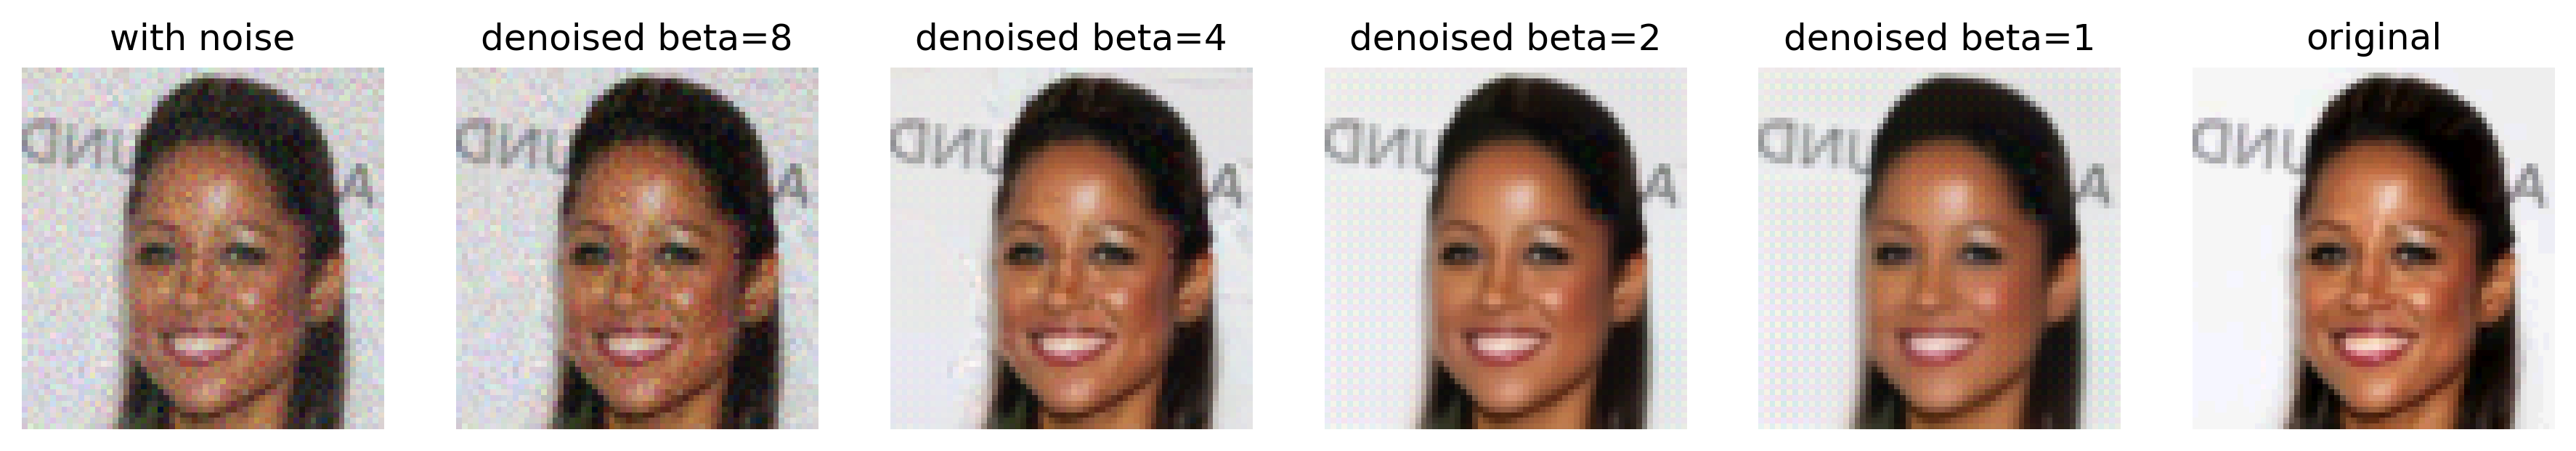

In [853]:


fig, ax = plt.subplots(1,6, figsize=(15,60), dpi=300)

ax[0].imshow(fit_range(noisy.squeeze().permute(1,2,0).numpy()))
ax[1].imshow(fit_range(denoised_8.squeeze().permute(1,2,0).numpy()))
ax[2].imshow(fit_range(denoised_4.squeeze().permute(1,2,0).numpy()))
ax[3].imshow(fit_range(denoised_2.squeeze().permute(1,2,0).numpy()))
ax[4].imshow(fit_range(denoised_1.squeeze().permute(1,2,0).numpy()))
ax[5].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
for a in ax:
    a.axis('off')
ax[0].set_title('with noise')
for i in range(4):
    ax[i+1].set_title(f'denoised beta={2**(3-i)}')
ax[5].set_title('original')

In [1050]:
ith = 25
clear = comparison_small[ith]['clear']
key_1 = (0.025, 2)
key_2 = (0.05, 2)
noisy_1 = comparison_small[ith]['deltas'][0][key_1]['noisy']
denoised_1 = comparison_small[ith]['deltas'][0][key_1]['denoised']
noisy_2 = comparison_small[ith]['deltas'][0][key_2]['noisy']
denoised_2 = comparison_small[ith]['deltas'][0][key_2]['denoised']

Text(0.5, 1.0, 'original')

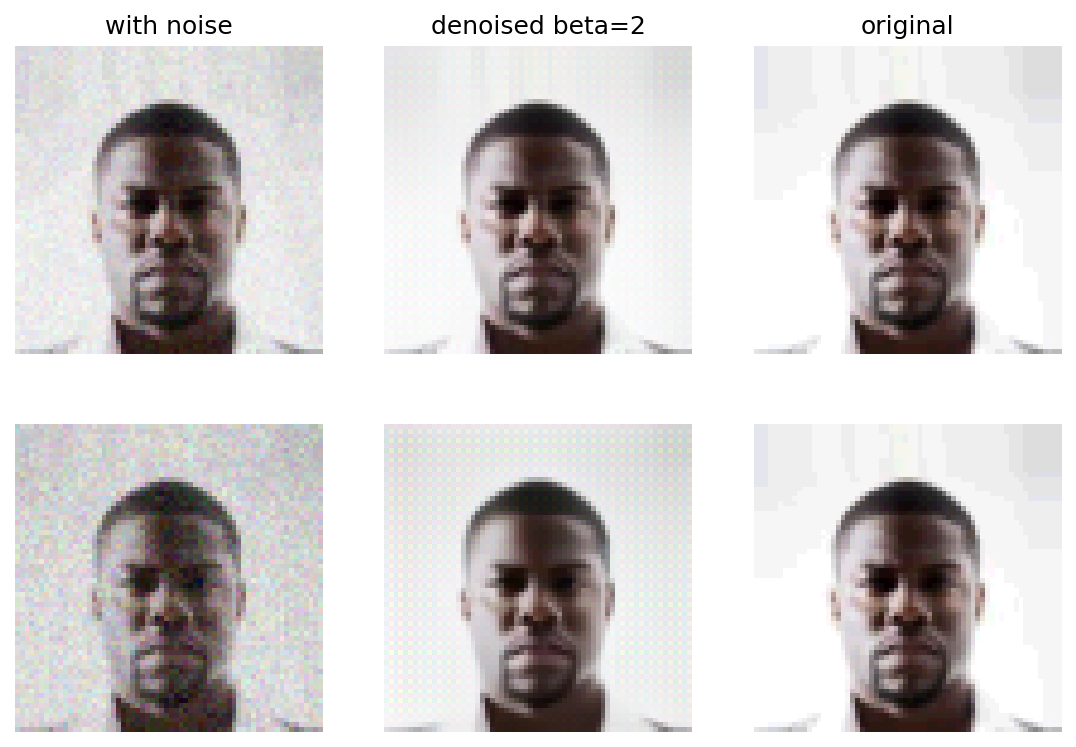

In [1051]:
fig, ax = plt.subplots(2,3, figsize=(9,6), dpi=150)

ax[0][0].imshow(fit_range(noisy_1.squeeze().permute(1,2,0).numpy()))
ax[0][1].imshow(fit_range(denoised_1.squeeze().permute(1,2,0).numpy()))
ax[0][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[1][0].imshow(fit_range(noisy_2.squeeze().permute(1,2,0).numpy()))
ax[1][1].imshow(fit_range(denoised_2.squeeze().permute(1,2,0).numpy()))
ax[1][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
for a in ax:
    for a in a:
        a.axis('off')
ax[0][0].set_title('with noise')
ax[0][1].set_title('denoised beta=2')
ax[0][2].set_title('original')

# Noise Gain

In [919]:
ith = 31
clear = comparison_big[ith]['clear']
key_1 = (0.025, 4)
key_2 = (0.05, 4)
s_noisy_1 = comparison_small[ith]['deltas'][0][key_1]['noisy']
s_denoised_1 = comparison_small[ith]['deltas'][0][key_1]['denoised']
s_noisy_2 = comparison_small[ith]['deltas'][0][key_2]['noisy']
s_denoised_2 = comparison_small[ith]['deltas'][0][key_2]['denoised']
key_1 = (0.1, 4)
key_2 = (0.2, 1)
b_noisy_1 = comparison_big[ith]['deltas'][0][key_1]['noisy']
b_denoised_1 = comparison_big[ith]['deltas'][0][key_1]['denoised']
b_noisy_2 = comparison_big[ith]['deltas'][0][key_2]['noisy']
b_denoised_2 = comparison_big[ith]['deltas'][0][key_2]['denoised']

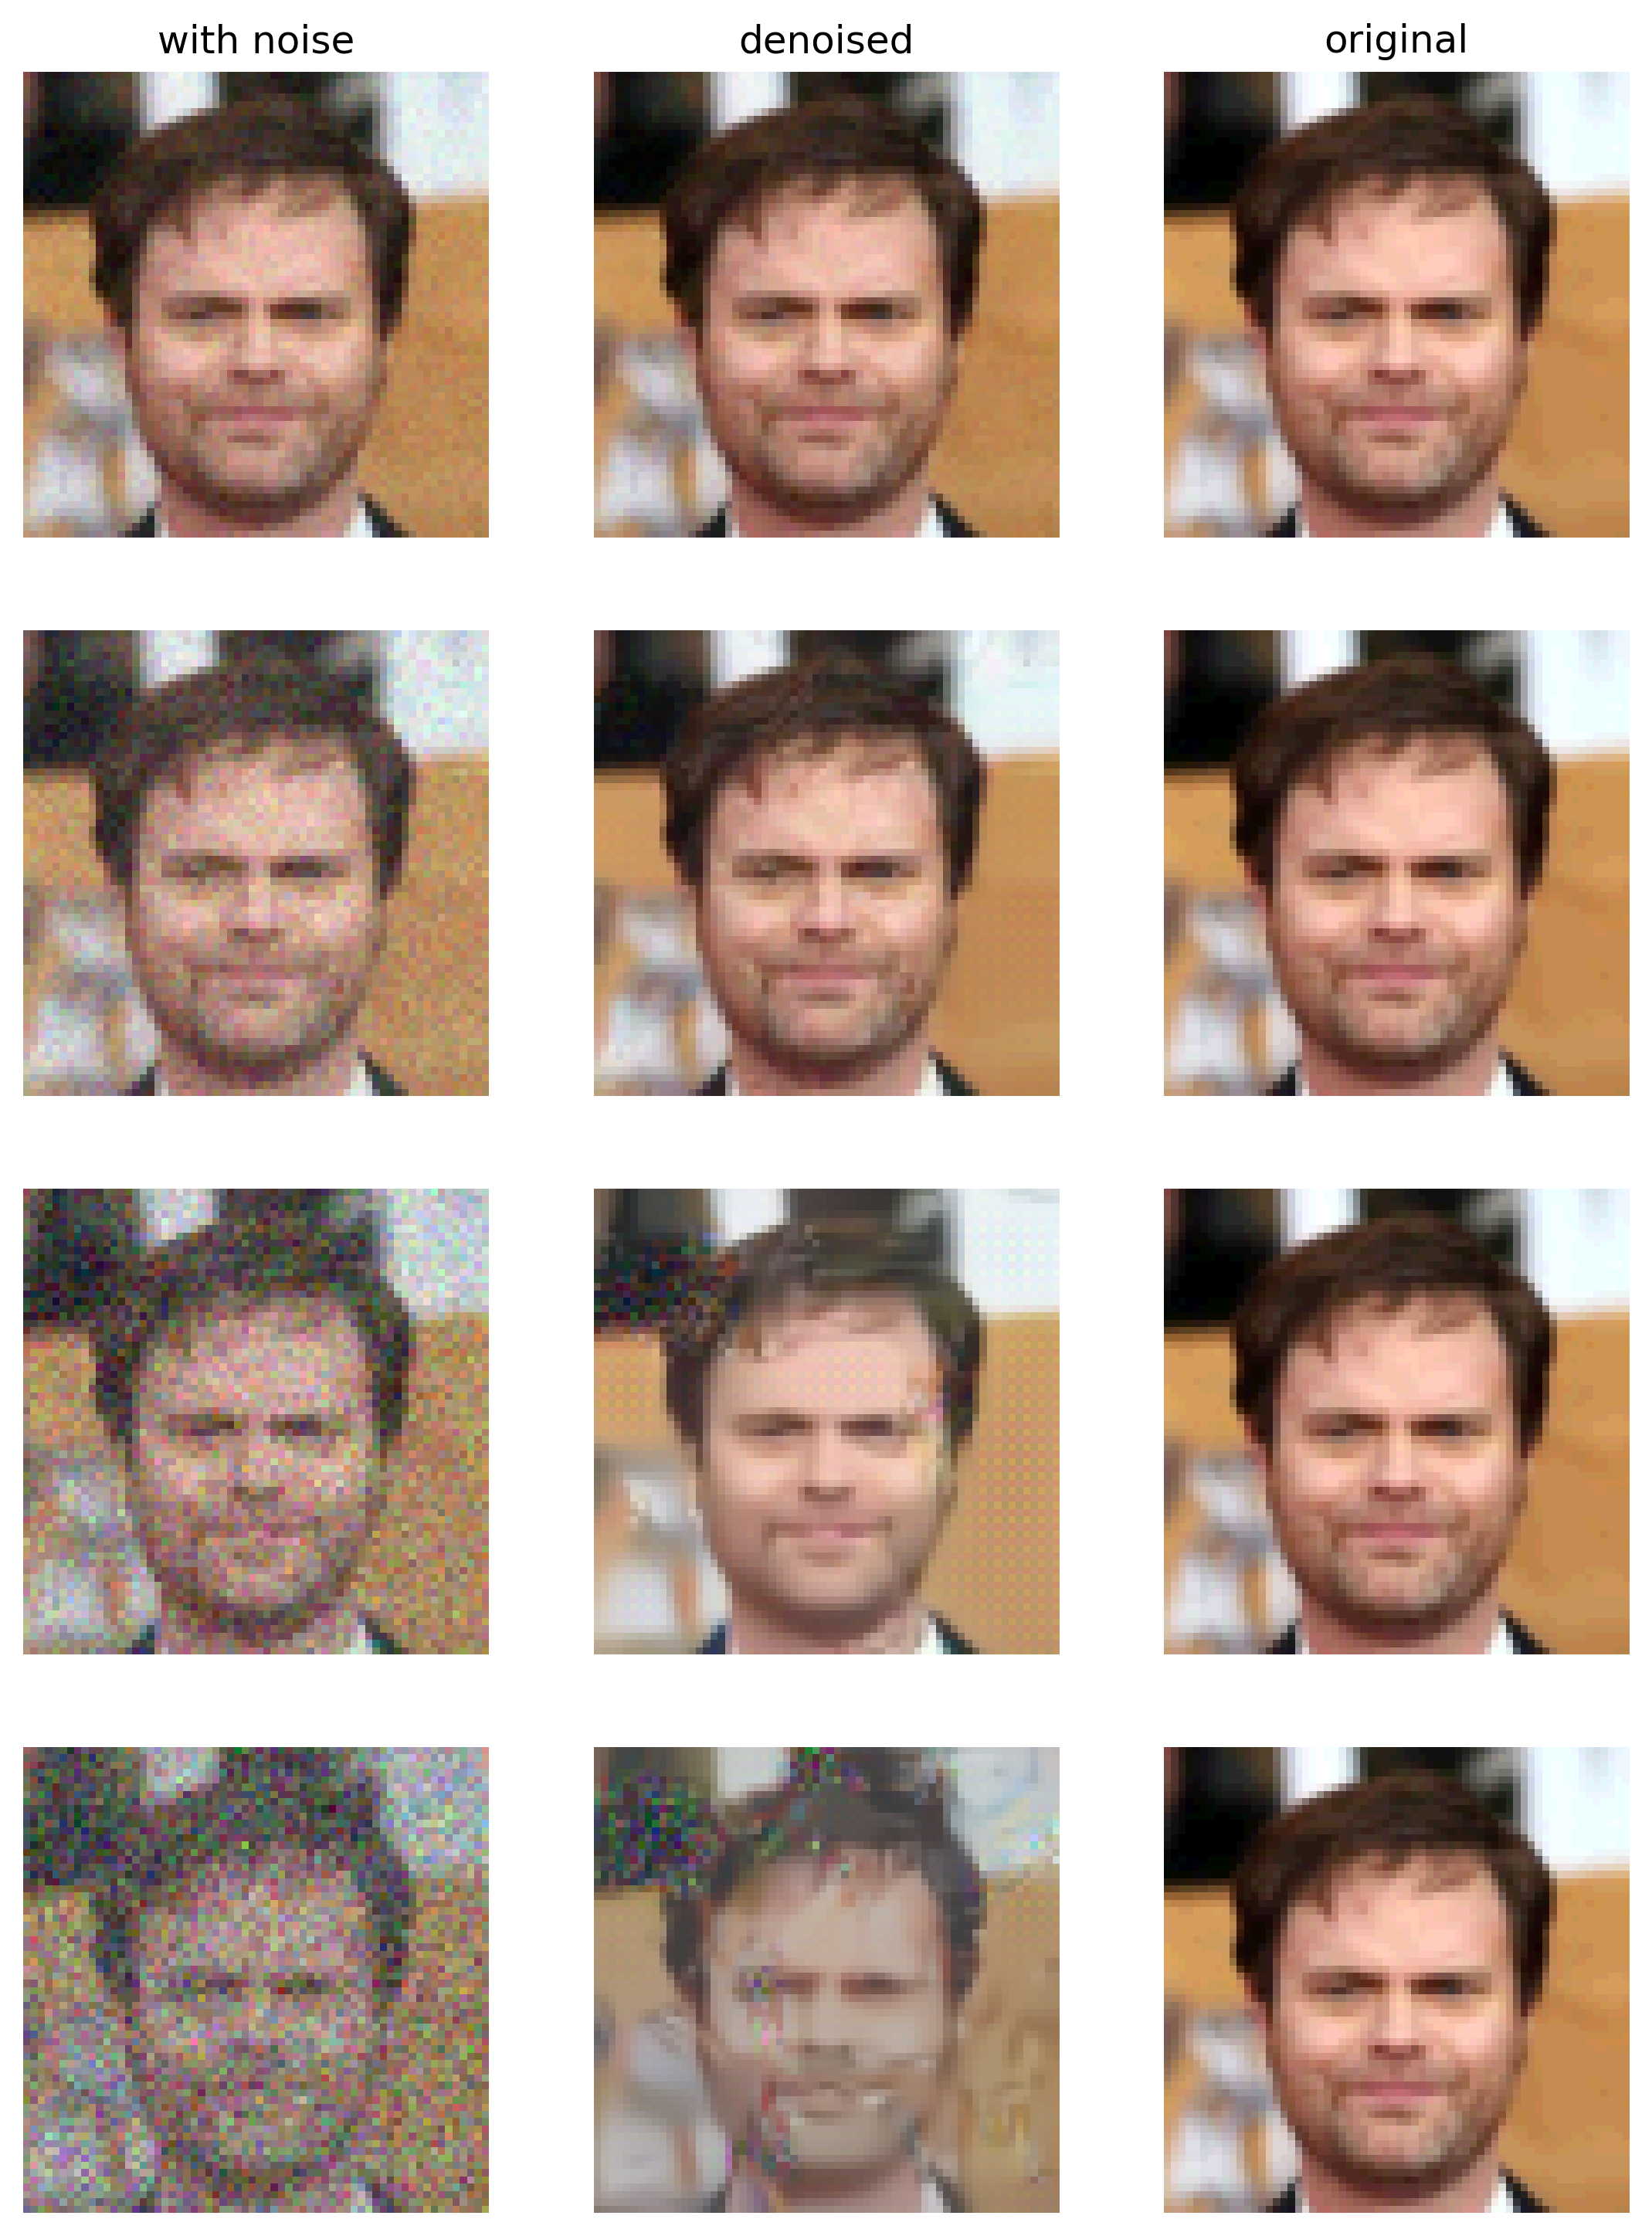

In [921]:
fig, ax = plt.subplots(4, 3, figsize=(9,12), dpi=300)

ax[0][0].imshow(fit_range(s_noisy_1.squeeze().permute(1,2,0).numpy()))
ax[0][1].imshow(fit_range(s_denoised_1.squeeze().permute(1,2,0).numpy()))
ax[0][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[1][0].imshow(fit_range(s_noisy_2.squeeze().permute(1,2,0).numpy()))
ax[1][1].imshow(fit_range(s_denoised_2.squeeze().permute(1,2,0).numpy()))
ax[1][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))

ax[2][0].imshow(fit_range(b_noisy_1.squeeze().permute(1,2,0).numpy()))
ax[2][1].imshow(fit_range(b_denoised_1.squeeze().permute(1,2,0).numpy()))
ax[2][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))
ax[3][0].imshow(fit_range(b_noisy_2.squeeze().permute(1,2,0).numpy()))
ax[3][1].imshow(fit_range(b_denoised_2.squeeze().permute(1,2,0).numpy()))
ax[3][2].imshow(fit_range(clear.squeeze().permute(1,2,0).numpy()))

for a in ax:
    for a in a:
        a.axis('off')
ax[0][0].set_title('with noise')
ax[0][1].set_title('denoised')
ax[0][2].set_title('original')

plt.savefig('different_gains.png')